# Dataset: FashionMNIST

In [1]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# resize to match MobileNetV2 input
transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=3), # Convert to 3 channels
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

# Load FashionMNIST Dataset
train_dataset = datasets.FashionMNIST(root='./data', train=True, transform=transform, download=True)
test_dataset = datasets.FashionMNIST(root='./data', train=False, transform=transform, download=True)

BATCH_SIZE = 32

# DataLoader
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [2]:
LABELS = {
    0: "T-shirt/top",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle boot",
}

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Current device:", DEVICE)

Current device: cuda


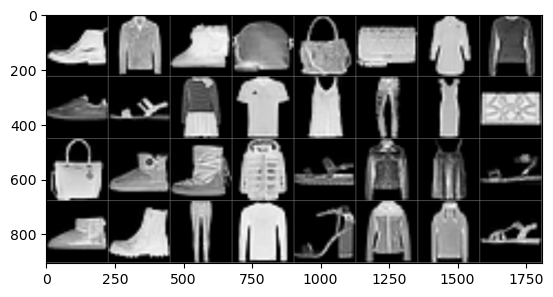

Labels: Ankle boot, Coat, Ankle boot, Bag, Bag, Bag, Shirt, Pullover, Sneaker, Sandal, Dress, T-shirt/top, T-shirt/top, Trouser, Dress, Bag, Bag, Ankle boot, Ankle boot, Coat, Sandal, Coat, T-shirt/top, Sandal, Ankle boot, Ankle boot, Trouser, Pullover, Sandal, Coat, Pullover, Sandal
Image shape: torch.Size([32, 3, 224, 224])


In [3]:
import numpy as np
import matplotlib.pyplot as plt
from torchvision import utils

def imshow(img):
    img = img / 2 + 0.5 
    img_np = img.numpy()
    plt.imshow(np.transpose(img_np, (1, 2, 0)))
    plt.show()


images, img_labels = next(iter(train_loader))
grid_img = utils.make_grid(images)

imshow(grid_img)
print("Labels:", ", ".join(f"{LABELS[img_labels[i].item()]}" for i in range(BATCH_SIZE)))
print("Image shape:", images.shape)

# Model: mobilenet_v2

In [4]:
from torchvision import models
from torchsummary import summary

import torch.nn as nn
import torch.optim as optim

model = models.mobilenet_v2(weights=models.MobileNet_V2_Weights.IMAGENET1K_V1)
model.classifier[1] = nn.Linear(model.last_channel, 10)  # For 10 CIFAR-10 classes
model = model.to(DEVICE)
summary(model, (3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 16, 16]             864
       BatchNorm2d-2           [-1, 32, 16, 16]              64
             ReLU6-3           [-1, 32, 16, 16]               0
            Conv2d-4           [-1, 32, 16, 16]             288
       BatchNorm2d-5           [-1, 32, 16, 16]              64
             ReLU6-6           [-1, 32, 16, 16]               0
            Conv2d-7           [-1, 16, 16, 16]             512
       BatchNorm2d-8           [-1, 16, 16, 16]              32
  InvertedResidual-9           [-1, 16, 16, 16]               0
           Conv2d-10           [-1, 96, 16, 16]           1,536
      BatchNorm2d-11           [-1, 96, 16, 16]             192
            ReLU6-12           [-1, 96, 16, 16]               0
           Conv2d-13             [-1, 96, 8, 8]             864
      BatchNorm2d-14             [-1, 9

## Train

In [5]:
LR = 0.001

criterion = nn.CrossEntropyLoss()
criterion.to(DEVICE)
optimizer = optim.Adam(model.parameters(), lr=LR)

In [6]:
N_EPOCH = 5
log_loss = []

for epoch in range(N_EPOCH):
    model.train()
    train_loss = 0

    for batch_id, (inputs, labels) in enumerate(train_loader):
        inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        train_loss += loss.item()
    
    train_loss /= len(train_loader)
    log_loss.append(train_loss)
    print(f"[{epoch + 1}] Loss: {train_loss:.5f}")

[1] Loss: 0.34408
[2] Loss: 0.24178
[3] Loss: 0.21560
[4] Loss: 0.19150
[5] Loss: 0.17639


In [7]:
torch.save(model.state_dict(), "./models/base.pth")

## Evaluate

In [8]:
model.eval()
correct = 0
total = 0

with torch.no_grad(): 
    for images, labels in test_loader:
        images, labels = images.to(DEVICE), labels.to(DEVICE)
        outputs = model(images)
        
        _, predicted = torch.max(outputs, 1)
        
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = 100 * correct / total
print(f"Accuracy: {accuracy:.2f}")

Accuracy: 92.71


# MLFlow

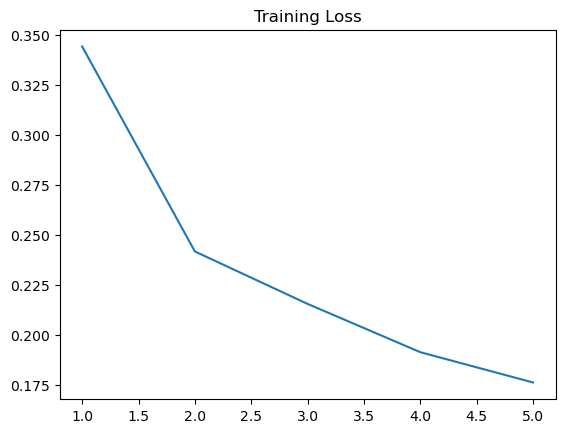

In [17]:
x = np.linspace(1, 5, 5)
plt.plot(x, log_loss)
plt.title("Training Loss")
plot_path = "./loss.png"
plt.savefig(plot_path)
plt.show()

In [18]:
import mlflow

mlflow.set_experiment("MobileNetV2")
with mlflow.start_run():
    mlflow.log_param("Learning-Rate", LR)
    mlflow.log_param("Batch-Size", BATCH_SIZE)
    mlflow.log_param("Iteration", N_EPOCH)

    mlflow.log_metric("Accuracy", accuracy)
    mlflow.log_artifact(plot_path)
    mlflow.pytorch.log_model(model, "MobileNet_model")

2025/01/10 22:44:39 WARNING mlflow.utils.requirements_utils: Found torch version (2.0.1+cu117) contains a local version label (+cu117). MLflow logged a pip requirement for this package as 'torch==2.0.1' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2025/01/10 22:44:43 WARNING mlflow.utils.requirements_utils: Found torchvision version (0.15.2+cu117) contains a local version label (+cu117). MLflow logged a pip requirement for this package as 'torchvision==0.15.2' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2025/01/10 22:44:43 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
